In [23]:
### This file is a part of the Syncpy library.
### Copyright 2015, ISIR / Universite Pierre et Marie Curie (UPMC)
### Main contributor(s): Giovanna Varni, Marie Avril, ELBANI Wail
### syncpy@isir.upmc.fr
### 
### This software is a computer program whose for investigating
### synchrony in a fast and exhaustive way. 
### 
### This software is governed by the CeCILL-B license under French law
### and abiding by the rules of distribution of free software.  You
### can use, modify and/ or redistribute the software under the terms
### of the CeCILL-B license as circulated by CEA, CNRS and INRIA at the
### following URL "http://www.cecill.info".

### As a counterpart to the access to the source code and rights to
### copy, modify and redistribute granted by the license, users are
### provided only with a limited warranty and the software's author,
### the holder of the economic rights, and the successive licensors
### have only limited liability.
### 
### In this respect, the user's attention is drawn to the risks
### associated with loading, using, modifying and/or developing or
### reproducing the software by the user in light of its specific
### status of free software, that may mean that it is complicated to
### manipulate, and that also therefore means that it is reserved for
### developers and experienced professionals having in-depth computer
### knowledge. Users are therefore encouraged to load and test the
### software's suitability as regards their requirements in conditions
### enabling the security of their systems and/or data to be ensured
### and, more generally, to use and operate it in the same conditions
### as regards security.
### 
### The fact that you are presently reading this means that you have
### had knowledge of the CeCILL-B license and that you accept its terms.

In [2]:
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import metrics
from time import time
import numpy as np 
import pandas as pd
import sys, os


C:\ProgramData\Anaconda3\envs\SyncPy\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Plot the reccurence matrix

In [28]:
    def plot_result(interpol='nearest'):
        """
        This method is not fully functional. it is used for test purposes only
        """
        x=[]
        y=[]
        plt.rcParams.update(plt.rcParamsDefault)

        for index, v in np.ndenumerate(self.res[0]):
            if v==1:
                x.append(index[0])
                y.append(index[1])
        
        H, xedges, yedges = np.histogram2d(x, y, normed=True)
        extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]
        plt.imshow(H, extent=extent, interpolation=interpol)
        plt.gca().invert_yaxis()
        plt.show()
        
        
    def plot_result2(Dij,threshold=0.01,w=200):   
        min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
        DijS = min_max_scaler.fit_transform(Dij)
        RijS= np.where(DijS - threshold < 0, 1, 0) 
        for i in range(RijS.shape[0]):
            for j in range(RijS.shape[1]):
                if not(j>=i-w and j<=i+w):
                    RijS[i][j] =0
        fig=plt.figure()             
        plt.imshow(RijS,cmap='Reds',  interpolation='nearest')
        plt.gca().invert_yaxis()
        plt.xlabel('frames')
        plt.ylabel('frames')
        plt.show()
     
        

## Loading STIP data

In [4]:
"""
 output: 
-data1: dataframe for the first videoc 'STIP' points
-data2: dataframe for the second video 'STIP' points
-hoghof: descriptor of both videos. We used a combination of  histogram of gradients and histogram of flow 
"""
        
print("################ loading data ######################")
        
        
        
'loading the STIP into a panda dataframe'
try:
    data1=pd.read_csv('data/wail.txt',header=None, sep=r"\s+",skiprows=3)
    data2=pd.read_csv('data/jean.txt',header=None, sep=r"\s+",skiprows=3)
except IOError as e:
    print('file not found')
           
            
'drop useless columns'
        
data1.drop(data1.columns[[0,1,2,4,5,6]], axis=1, inplace=True)
data2.drop(data2.columns[[0,1,2,4,5,6]], axis=1, inplace=True)
        
'columns names'
        
column=["hgf"+str(i) for i in range(162)]
column.insert(0,'frame')
        
'naming the columns'
data1.columns=column
data2.columns=column
        
' Working in the same frame range'
data1=data1[(data1.frame>=max(min(data1.frame),min(data2.frame))) & (data1.frame<=min(max(data1.frame),max(data2.frame)))]
data2=data2[(data2.frame>=max(min(data1.frame),min(data2.frame))) & (data2.frame<=min(max(data1.frame),max(data2.frame)))]
        
'merging the two dataframes'
data=data1.append(data2,ignore_index=True)
data=data.drop(['frame'],axis=1)

print('DATA SHAPE'+str(data.shape))

print(data.head())

################ loading data ######################
DATA SHAPE(10452, 162)
       hgf0      hgf1      hgf2      hgf3      hgf4      hgf5      hgf6  \
0  0.970961  0.000000  0.000000  0.029039  0.450444  0.000000  0.167810   
1  1.000000  0.000000  0.000000  0.000000  0.748810  0.005761  0.051104   
2  0.518194  0.229135  0.039248  0.213423  0.425319  0.257645  0.173135   
3  0.984047  0.000000  0.000000  0.015953  0.697598  0.000000  0.034941   
4  0.772069  0.142789  0.010936  0.074205  0.959708  0.027886  0.000592   

       hgf7      hgf8      hgf9    ...       hgf152    hgf153    hgf154  \
0  0.381747  0.266640  0.000000    ...     0.485207  0.005072  0.000000   
1  0.194325  0.653199  0.003206    ...     0.735450  0.000000  0.000000   
2  0.143901  0.349560  0.078921    ...     0.862215  0.000000  0.000000   
3  0.267461  0.920963  0.002877    ...     0.106509  0.000000  0.000000   
4  0.011814  0.905663  0.092930    ...     0.182587  0.000000  0.038039   

     hgf155    hgf156 

## Apply Kmean on data: create visual dictionary

In [5]:
"""
 input:
-data: hoghf descriptor
-K: the size of the dictionary
output:
-Kmean classifier
descrition: apply Kmeans
"""
K=64
t0 = time()
kmean= KMeans(init='k-means++', n_clusters=K, n_init=10) 
kmean.fit(data)
t=time()
print("training  time for kmeans------:"+str(t-t0))
print("silhouette ------:"+str(metrics.silhouette_score(data, kmean.labels_,metric='euclidean')))


training  time for kmeans------:25.067433834075928
silhouette ------:0.0699053454118


## Generate histograms

In [6]:
 def histograms(data,K,kmean):
        """
        -input:
            -data: hoghof descriptor
            -number of principal component (comes from applying pca) 
            -K: number of words in the codebook or the codewords or visual vocabulary or K means number of clusters
        """
        i=0
        gbp=data
        predclust=kmean.predict(preprocessing.scale(data.drop(['frame'],axis=1)))
        gbp['pred']=predclust
        gbp=gbp.groupby('frame')
        train=np.zeros((len(gbp),K))
        for name,group in gbp:
            train[i][group.pred.values]=1
            i+=1
           
         
        return train
    

In [7]:
print('histograms that decribe wail action')
h1=histograms(data1,K,kmean)
print(h1)

print('histogram that describe jean action')
h2=histograms(data2,K,kmean)
print(h2)






histograms that decribe wail action
[[ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
histogram that describe jean action
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


## Training one-class SVM on histograms

In [8]:
    def OneSVM_predict(h,my_kernel):
        nuu=Cross_validation(h)
        print('nu coeficient is:    '+str(nuu))
        onesvm = svm.OneClassSVM( kernel=my_kernel,nu=nuu)
        onesvm.fit(h)
        return onesvm
    
    def Cross_validation(h):
        n_folds=4
        nu=np.linspace(0.001, 1, 1000)
        results=[]
        for d in nu:
            onesvm = svm.OneClassSVM( kernel=my_kernel, nu=d)
            hypothesisresults=[]
            for train, test in KFold(len(h), n_folds):
                onesvm.fit(h[train]) # fit
                hypothesisresults.append(np.mean(onesvm.predict(h[test])==1))
            
            results.append(np.mean(hypothesisresults))
        
        
        
        return nu[np.argmax(results)]
    
    
    def my_kernel(X,Y):
    
        return X.dot(Y.T)

In [9]:
print('####### Training one SVM #########')
svm1=OneSVM_predict(h1,my_kernel)
svm2=OneSVM_predict(h2,my_kernel)


####### Training one SVM #########
nu coeficient is:    0.029
nu coeficient is:    0.041


## Similarity scores between Wail and Jean 

In [12]:
Sab1=(svm1.decision_function(h2)-svm1.intercept_)
Sab2=(svm2.decision_function(h1)-svm1.intercept_)
print("Model wail applied to jean")
print(Sab1)
print("Model jean applied to wail")
print(Sab1)


Model wail applied to jean
[[  5.49921485e-01]
 [  5.49921485e-01]
 [  5.49921485e-01]
 ..., 
 [  4.39947967e+00]
 [  5.09281487e-04]
 [  5.09281487e-04]]
Model jean applied to wail
[[  5.49921485e-01]
 [  5.49921485e-01]
 [  5.49921485e-01]
 ..., 
 [  4.39947967e+00]
 [  5.09281487e-04]
 [  5.09281487e-04]]


### Calculating and ploting recurrence matrix

In [17]:
 """
input:
-h1,h2 histograms 
output:
-Rij:Recurrence matrix
-Dij:Raw Recurrence matrix (before applying the threshold)
"""
threshold=0.01 # 

Rij=np.zeros((h1.shape[0],h2.shape[0]))
Dij=np.zeros((h1.shape[0],h2.shape[0]))
      
for i in range(h1.shape[0]):
    for j in range(h2.shape[0]):
        Rij[i][j]=np.where(np.square(Sab1[j]-Sab2[i])-threshold <0, 1, 0 )
        Dij[i][j]= np.square(Sab1[j]-Sab2[i])
                
    


In [19]:
print("recurrence matrix before applying threshold")
print(Dij)

recurrence matrix before applying threshold
[[  1.45704744e-07   1.45704744e-07   1.45704744e-07 ...,   1.48161595e+01
    3.02273350e-01   3.02273350e-01]
 [  1.63163185e-09   1.63163185e-09   1.63163185e-09 ...,   1.48187872e+01
    3.01898156e-01   3.01898156e-01]
 [  2.86804613e+00   2.86804613e+00   2.86804613e+00 ...,   4.64845465e+00
    5.03079274e+00   5.03079274e+00]
 ..., 
 [  7.17068084e-01   7.17068084e-01   7.17068084e-01 ...,   9.01656437e+00
    1.94940496e+00   1.94940496e+00]
 [  7.17098227e-01   7.17098227e-01   7.17098227e-01 ...,   9.01645749e+00
    1.94945466e+00   1.94945466e+00]
 [  1.79568313e-01   1.79568313e-01   1.79568313e-01 ...,   1.17361274e+01
    9.47054436e-01   9.47054436e-01]]


In [20]:
print("recurrence matrix after applying threshold")
print(Rij)

recurrence matrix after applying threshold
[[ 1.  1.  1. ...,  0.  0.  0.]
 [ 1.  1.  1. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


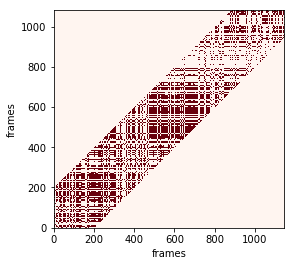

In [29]:
plot_result2(Dij,threshold=0.01,w=200)